In [ ]:
!pip install optuna[dashboard] --quiet

In [ ]:
!pip install shap -q

In [ ]:
# ===========================
# XGBoost + SHAP (LabelEncoder + Display Features for Categorical Labels)
# ===========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import joblib
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from collections import defaultdict

# Load your dataset
X_full = pd.read_csv("/content/sample_data/covidstress_processed_data_v2.csv")
y = X_full.pop("perceived_stress_level").map({"low": 0, "high": 1})

# Keep raw copy for display in SHAP plots
X_display = X_full.copy()

# Encode categorical features for model training
X_encoded = X_full.copy()
label_encoders = {}

for col in X_encoded.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

# Display label encoder mappings
print("\n=== Label Encoder Mappings ===")
for col, encoder in label_encoders.items():
    print(f"\nFeature: {col}")
    print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

np.random.seed(32824)
seeds = np.random.randint(0, 1000, size=5)
n_seeds = len(seeds)

metrics_accumulator = defaultdict(lambda: defaultdict(float))

# === Training and saving model per seed ===
macro_f1_scores = []
weighted_f1_scores = []

for seed in seeds:
    print(f"\n--- Training for Seed: {seed} ---")

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_encoded, y, test_size=0.2, stratify=y, random_state=seed
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=seed
    )

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "use_label_encoder": False,
            "eval_metric": "logloss",
            "random_state": seed
        }
        model = XGBClassifier(**params)
        return cross_val_score(model, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1).mean()

    sampler = TPESampler(seed=seed)

    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    study_name = f"xgb_study_seed_{seed}_{timestamp}"

    study = optuna.create_study(
        direction="maximize",
        study_name=study_name,
        storage=f"sqlite:///xgb_stress_seed_{seed}.db",
        load_if_exists=False,
        sampler=sampler
    )
    study.optimize(objective, n_trials=30)

    best_params = study.best_params
    model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss", random_state=seed)
    model.fit(X_train, y_train)

    # Save model and corresponding test sets
    joblib.dump(model, f"xgb_model_seed_{seed}.pkl")
    joblib.dump(X_test, f"X_test_seed_{seed}.pkl")
    joblib.dump(X_display.iloc[X_test.index], f"X_display_seed_{seed}.pkl")

    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    report = classification_report(y_val, y_pred, target_names=["low", "high"], output_dict=True)

    # Store macro F1 score per seed
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]

    macro_f1_scores.append(macro_f1)
    weighted_f1_scores.append(weighted_f1)


    for class_label, scores in report.items():
        if isinstance(scores, dict):
            for metric, value in scores.items():
                metrics_accumulator[class_label][metric] += value

    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["low", "high"], yticklabels=["low", "high"])
    plt.title(f"Validation Confusion Matrix (Seed {seed})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"xgb_conf_matrix_validation_seed_{seed}.png")
    plt.close()

print("\n=== Average Metrics Across Seeds ===")
for class_label, metrics in metrics_accumulator.items():
    print(f"\nClass: {class_label}")
    for metric, total in metrics.items():
        print(f"{metric}: {total / n_seeds:.4f}")

[I 2025-10-15 13:57:40,783] A new study created in RDB with name: xgb_study_seed_970_20251015135740



=== Label Encoder Mappings ===

Feature: gender
{'Female': np.int64(0), 'Male': np.int64(1)}

Feature: residing_country
{'Brazil': np.int64(0), 'Bulgaria': np.int64(1), 'Colombia': np.int64(2), 'Costa Rica': np.int64(3), 'Czech Republic': np.int64(4), 'Ecuador': np.int64(5), 'Estonia': np.int64(6), 'Finland': np.int64(7), 'Guatemala': np.int64(8), 'Honduras': np.int64(9), 'Ireland': np.int64(10), 'Italy': np.int64(11), 'Japan': np.int64(12), 'Kyrgyzstan': np.int64(13), 'Malaysia': np.int64(14), 'Norway': np.int64(15), 'Portugal': np.int64(16), 'Russian Federation': np.int64(17), 'Slovakia': np.int64(18), 'Spain': np.int64(19), 'Switzerland': np.int64(20), 'Taiwan': np.int64(21), 'Ukraine': np.int64(22), 'Uruguay': np.int64(23)}

Feature: education_level
{'PhD / Doctorate': np.int64(0), 'Some University or equivalent': np.int64(1), 'University degree': np.int64(2), 'Up to 12 years of school': np.int64(3), 'less than 12 years of school': np.int64(4)}

Feature: employment_status
{'Employ

[I 2025-10-15 13:57:41,869] Trial 0 finished with value: 0.6140189526701191 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.2580031979844215, 'subsample': 0.9710722595136896, 'colsample_bytree': 0.5235885302274887}. Best is trial 0 with value: 0.6140189526701191.
[I 2025-10-15 13:57:43,062] Trial 1 finished with value: 0.5956149130637367 and parameters: {'n_estimators': 148, 'max_depth': 9, 'learning_rate': 0.2605768931614403, 'subsample': 0.603514666092789, 'colsample_bytree': 0.7771888821951614}. Best is trial 0 with value: 0.6140189526701191.
[I 2025-10-15 13:57:44,154] Trial 2 finished with value: 0.6118880906353565 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.21017574646746431, 'subsample': 0.7013100234908853, 'colsample_bytree': 0.5627454883506015}. Best is trial 0 with value: 0.6140189526701191.
[I 2025-10-15 13:57:45,057] Trial 3 finished with value: 0.603906937443565 and parameters: {'n_estimators': 172, 'max_depth': 6, 'lea

Validation Accuracy: 0.6487


[I 2025-10-15 13:58:33,620] A new study created in RDB with name: xgb_study_seed_200_20251015135833



--- Training for Seed: 200 ---


[I 2025-10-15 13:58:34,953] Trial 0 finished with value: 0.6103154382167731 and parameters: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.18238184187342843, 'subsample': 0.7141543424648473, 'colsample_bytree': 0.882070343276935}. Best is trial 0 with value: 0.6103154382167731.
[I 2025-10-15 13:58:35,675] Trial 1 finished with value: 0.6124215450025089 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.27381151684253346, 'subsample': 0.7280404927291264, 'colsample_bytree': 0.9909013545791643}. Best is trial 1 with value: 0.6124215450025089.
[I 2025-10-15 13:58:37,962] Trial 2 finished with value: 0.5930685513207731 and parameters: {'n_estimators': 274, 'max_depth': 10, 'learning_rate': 0.2777473449332623, 'subsample': 0.651846656980814, 'colsample_bytree': 0.9230517451587777}. Best is trial 1 with value: 0.6124215450025089.
[I 2025-10-15 13:58:39,032] Trial 3 finished with value: 0.6186174588415952 and parameters: {'n_estimators': 124, 'max_depth': 9, 'l

Validation Accuracy: 0.6467


[I 2025-10-15 13:59:10,494] A new study created in RDB with name: xgb_study_seed_20_20251015135910



--- Training for Seed: 20 ---


[I 2025-10-15 13:59:12,412] Trial 0 finished with value: 0.5902078445611616 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.2685439115476653, 'subsample': 0.907918738653842, 'colsample_bytree': 0.5179447928084266}. Best is trial 0 with value: 0.5902078445611616.
[I 2025-10-15 13:59:14,330] Trial 1 finished with value: 0.6010586537222332 and parameters: {'n_estimators': 239, 'max_depth': 7, 'learning_rate': 0.16036817417994337, 'subsample': 0.8289757327794065, 'colsample_bytree': 0.5969251089414742}. Best is trial 1 with value: 0.6010586537222332.
[I 2025-10-15 13:59:15,599] Trial 2 finished with value: 0.594084125857268 and parameters: {'n_estimators': 154, 'max_depth': 9, 'learning_rate': 0.23707104674311302, 'subsample': 0.9251638198874976, 'colsample_bytree': 0.8876224469971814}. Best is trial 1 with value: 0.6010586537222332.
[I 2025-10-15 13:59:16,240] Trial 3 finished with value: 0.6149806278797292 and parameters: {'n_estimators': 107, 'max_depth': 5, 'l

Validation Accuracy: 0.6629


[I 2025-10-15 13:59:44,739] A new study created in RDB with name: xgb_study_seed_452_20251015135944



--- Training for Seed: 452 ---


[I 2025-10-15 13:59:46,208] Trial 0 finished with value: 0.5956764310692362 and parameters: {'n_estimators': 278, 'max_depth': 7, 'learning_rate': 0.27090968600174886, 'subsample': 0.9398816289031111, 'colsample_bytree': 0.5387910283700423}. Best is trial 0 with value: 0.5956764310692362.
[I 2025-10-15 13:59:47,488] Trial 1 finished with value: 0.6146515436509004 and parameters: {'n_estimators': 187, 'max_depth': 5, 'learning_rate': 0.14455454496476233, 'subsample': 0.5711312301267726, 'colsample_bytree': 0.571187241312936}. Best is trial 1 with value: 0.6146515436509004.
[I 2025-10-15 13:59:49,134] Trial 2 finished with value: 0.592133130318004 and parameters: {'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.25650996066799603, 'subsample': 0.7838092001254215, 'colsample_bytree': 0.9378263283601022}. Best is trial 1 with value: 0.6146515436509004.
[I 2025-10-15 13:59:50,772] Trial 3 finished with value: 0.6138587841335339 and parameters: {'n_estimators': 280, 'max_depth': 6, 'l

Validation Accuracy: 0.6552


[I 2025-10-15 14:00:29,981] A new study created in RDB with name: xgb_study_seed_97_20251015140029



--- Training for Seed: 97 ---


[I 2025-10-15 14:00:32,452] Trial 0 finished with value: 0.596291680480981 and parameters: {'n_estimators': 268, 'max_depth': 10, 'learning_rate': 0.13967459772583832, 'subsample': 0.6422905045143158, 'colsample_bytree': 0.8856082940048771}. Best is trial 0 with value: 0.596291680480981.
[I 2025-10-15 14:00:33,895] Trial 1 finished with value: 0.5974390674580441 and parameters: {'n_estimators': 160, 'max_depth': 10, 'learning_rate': 0.2794540727783435, 'subsample': 0.6023370328694622, 'colsample_bytree': 0.6725717586108098}. Best is trial 1 with value: 0.5974390674580441.
[I 2025-10-15 14:00:34,637] Trial 2 finished with value: 0.625937559677338 and parameters: {'n_estimators': 142, 'max_depth': 6, 'learning_rate': 0.10965862586797555, 'subsample': 0.9549811094003302, 'colsample_bytree': 0.567820897744423}. Best is trial 2 with value: 0.625937559677338.
[I 2025-10-15 14:00:35,342] Trial 3 finished with value: 0.6338677944856109 and parameters: {'n_estimators': 139, 'max_depth': 5, 'lea

Validation Accuracy: 0.6503

=== Average Metrics Across Seeds ===

Class: low
precision: 0.6735
recall: 0.7802
f1-score: 0.7229
support: 1433.0000

Class: high
precision: 0.6103
recall: 0.4763
f1-score: 0.5350
support: 1035.0000

Class: macro avg
precision: 0.6419
recall: 0.6283
f1-score: 0.6290
support: 2468.0000

Class: weighted avg
precision: 0.6470
recall: 0.6528
f1-score: 0.6441
support: 2468.0000


In [ ]:
# Analyze stability
print("\n=== F1-Score Stability Analysis ===")
print("Macro F1 - Mean:", np.mean(macro_f1_scores))
print("Macro F1 - Std Dev:", np.std(macro_f1_scores))
print("Macro F1 - Variance:", np.var(macro_f1_scores))

print("Weighted F1 - Mean:", np.mean(weighted_f1_scores))
print("Weighted F1 - Std Dev:", np.std(weighted_f1_scores))
print("Weighted F1 - Variance:", np.var(weighted_f1_scores))


=== F1-Score Stability Analysis ===
Macro F1 - Mean: 0.6289540886995562
Macro F1 - Std Dev: 0.005672298023222015
Macro F1 - Variance: 3.2174964864248374e-05
Weighted F1 - Mean: 0.6441051529324712
Weighted F1 - Std Dev: 0.005578409908996841
Weighted F1 - Variance: 3.111865711279414e-05


In [ ]:
# ========== SHAP ANALYSIS ==========
shap_values_list = []
expected_values = []
X_test_list = []
X_display_list = []

for seed in seeds:
    print(f"\n>> SHAP for Seed: {seed}")

    model = joblib.load(f"xgb_model_seed_{seed}.pkl")
    X_test = joblib.load(f"X_test_seed_{seed}.pkl")
    X_disp = joblib.load(f"X_display_seed_{seed}.pkl")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    shap_values_list.append(shap_values)
    expected_values.append(explainer.expected_value)
    X_test_list.append(X_test.reset_index(drop=True))
    X_display_list.append(X_disp.reset_index(drop=True))

# Average SHAP values
shap_values_avg = np.mean(shap_values_list, axis=0)
expected_value_avg = np.mean(expected_values)
X_test_final = X_test_list[0]
X_display_final = X_display_list[0]


>> SHAP for Seed: 970

>> SHAP for Seed: 200

>> SHAP for Seed: 20

>> SHAP for Seed: 452

>> SHAP for Seed: 97


/tmp/ipython-input-674423984.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_avg, X_test_final, plot_type="bar", feature_names=X_display_final.columns)


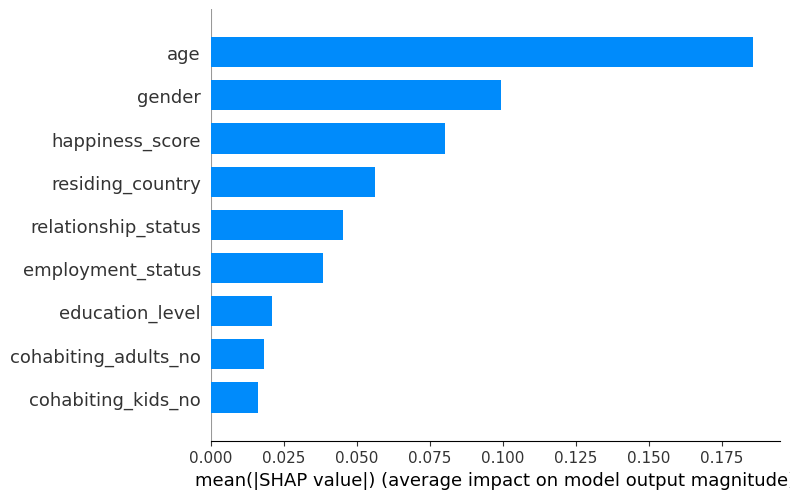

In [ ]:
# SHAP Visualizations
shap.initjs()
#Bar Plot
shap.summary_plot(shap_values_avg, X_test_final, plot_type="bar", feature_names=X_display_final.columns)


/tmp/ipython-input-666225615.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_avg, X_test_final, feature_names=X_display_final.columns)


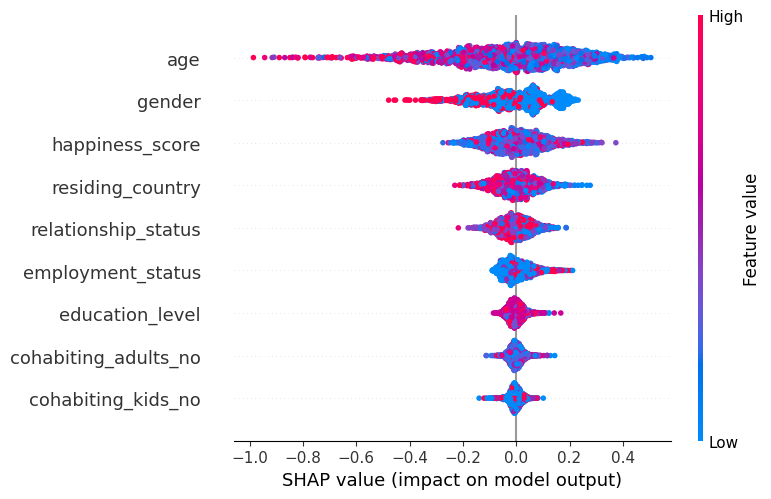

In [ ]:
# Dot plot
shap.summary_plot(shap_values_avg, X_test_final, feature_names=X_display_final.columns)


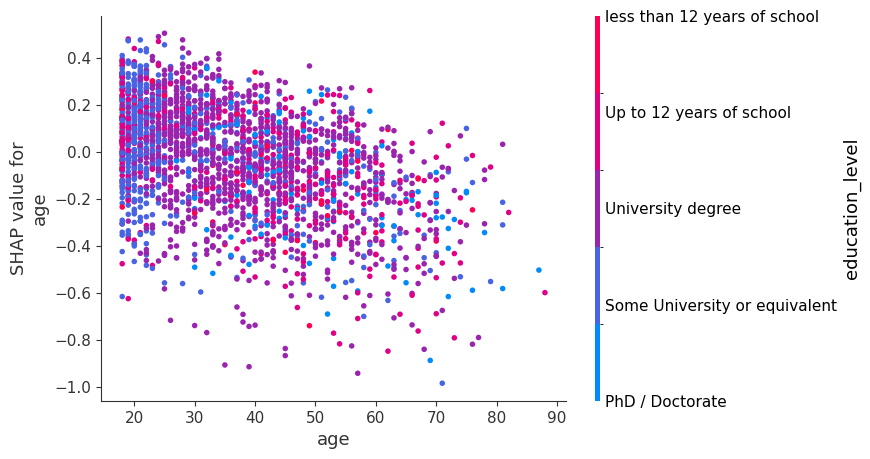

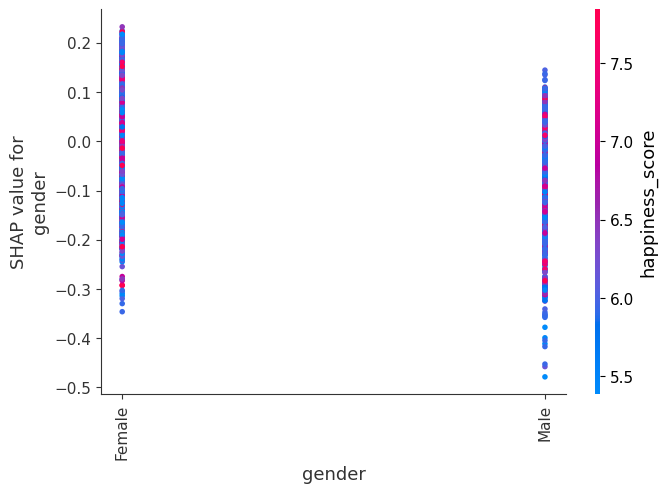

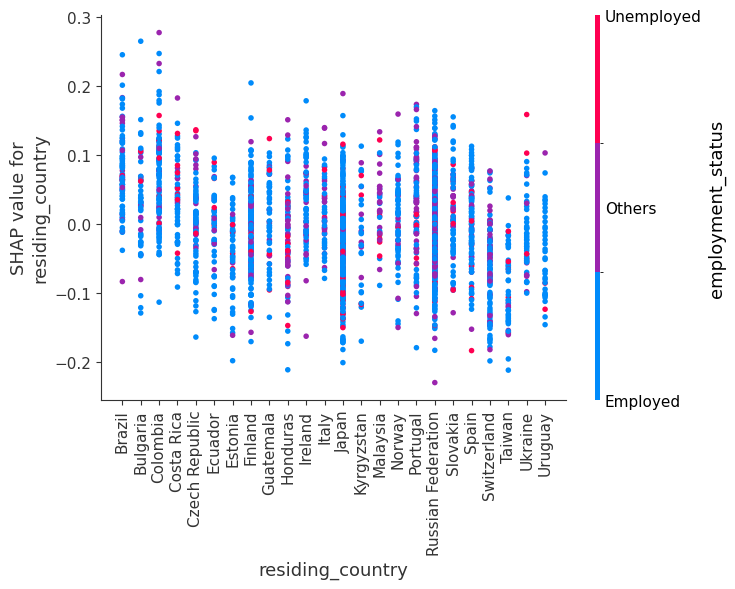

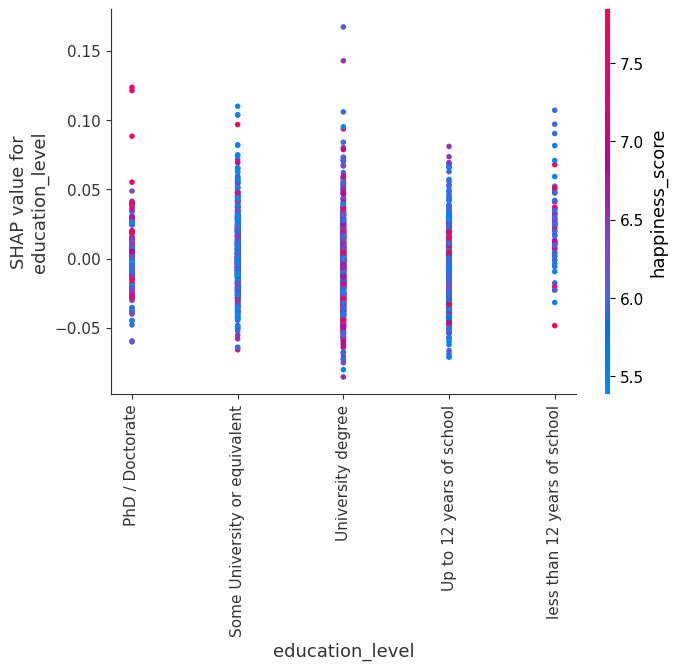

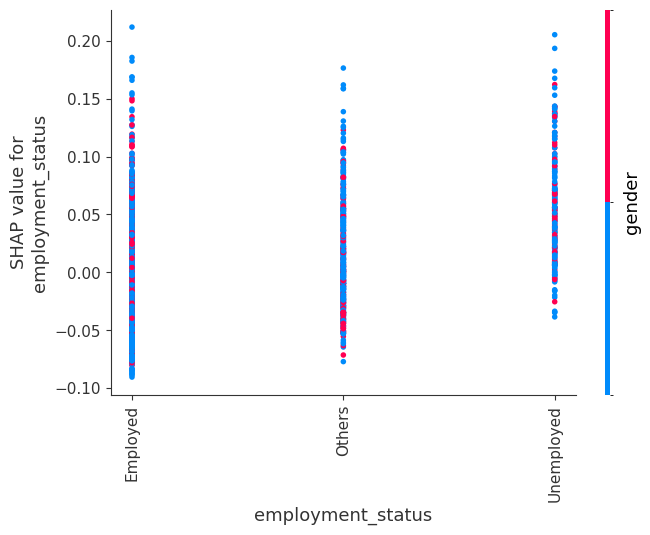

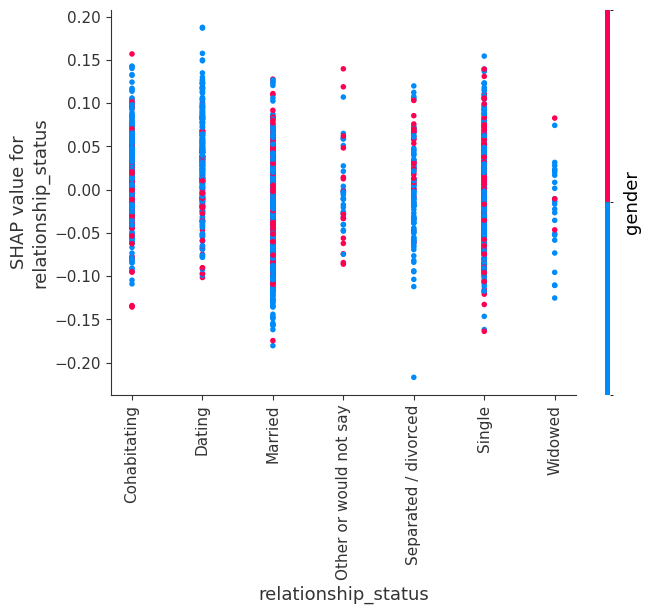

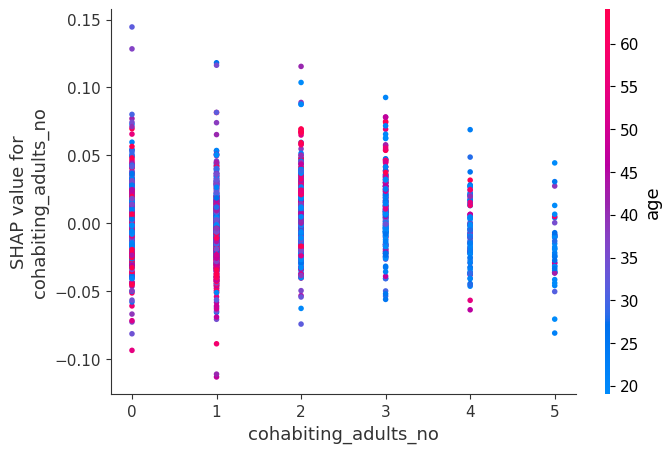

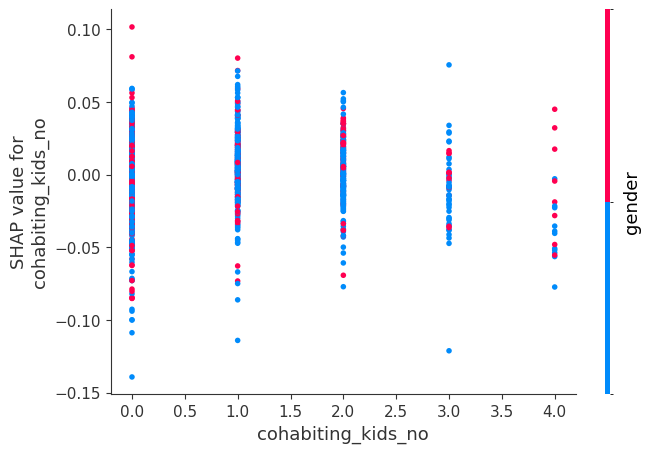

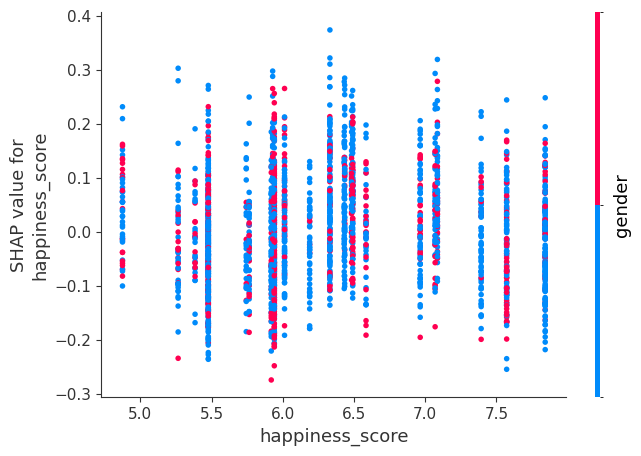

In [ ]:
# Dependence plots with readable categorical labels

for name in X_test_final.columns:
    shap.dependence_plot(
        name,
        shap_values_avg,
        X_test_final,
        display_features=X_display_final
    )


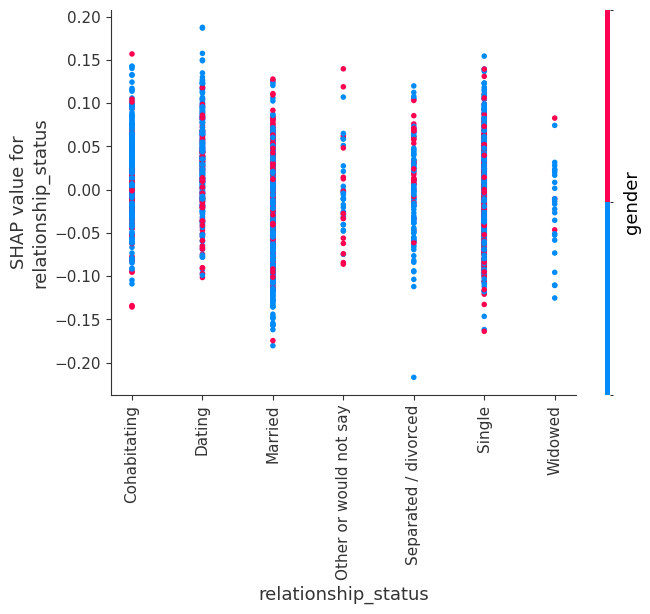

In [ ]:
shap.dependence_plot(
    "relationship_status",
    shap_values_avg,
    X_test_final,
    display_features=X_display_final,
    interaction_index="gender"
)
plt.show()
